In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.plot import show, adjust_band
from matplotlib import cm
import matplotlib
from scipy import stats

from constants import *
os.chdir(home_dir)
import datetime
tmp = []
for i in range(len(fire_sn)):
    tmp.append(datetime.datetime.strptime(fire_sn['Ig_Date'][i], '%Y-%m-%d'))
fire_sn['dt'] = tmp

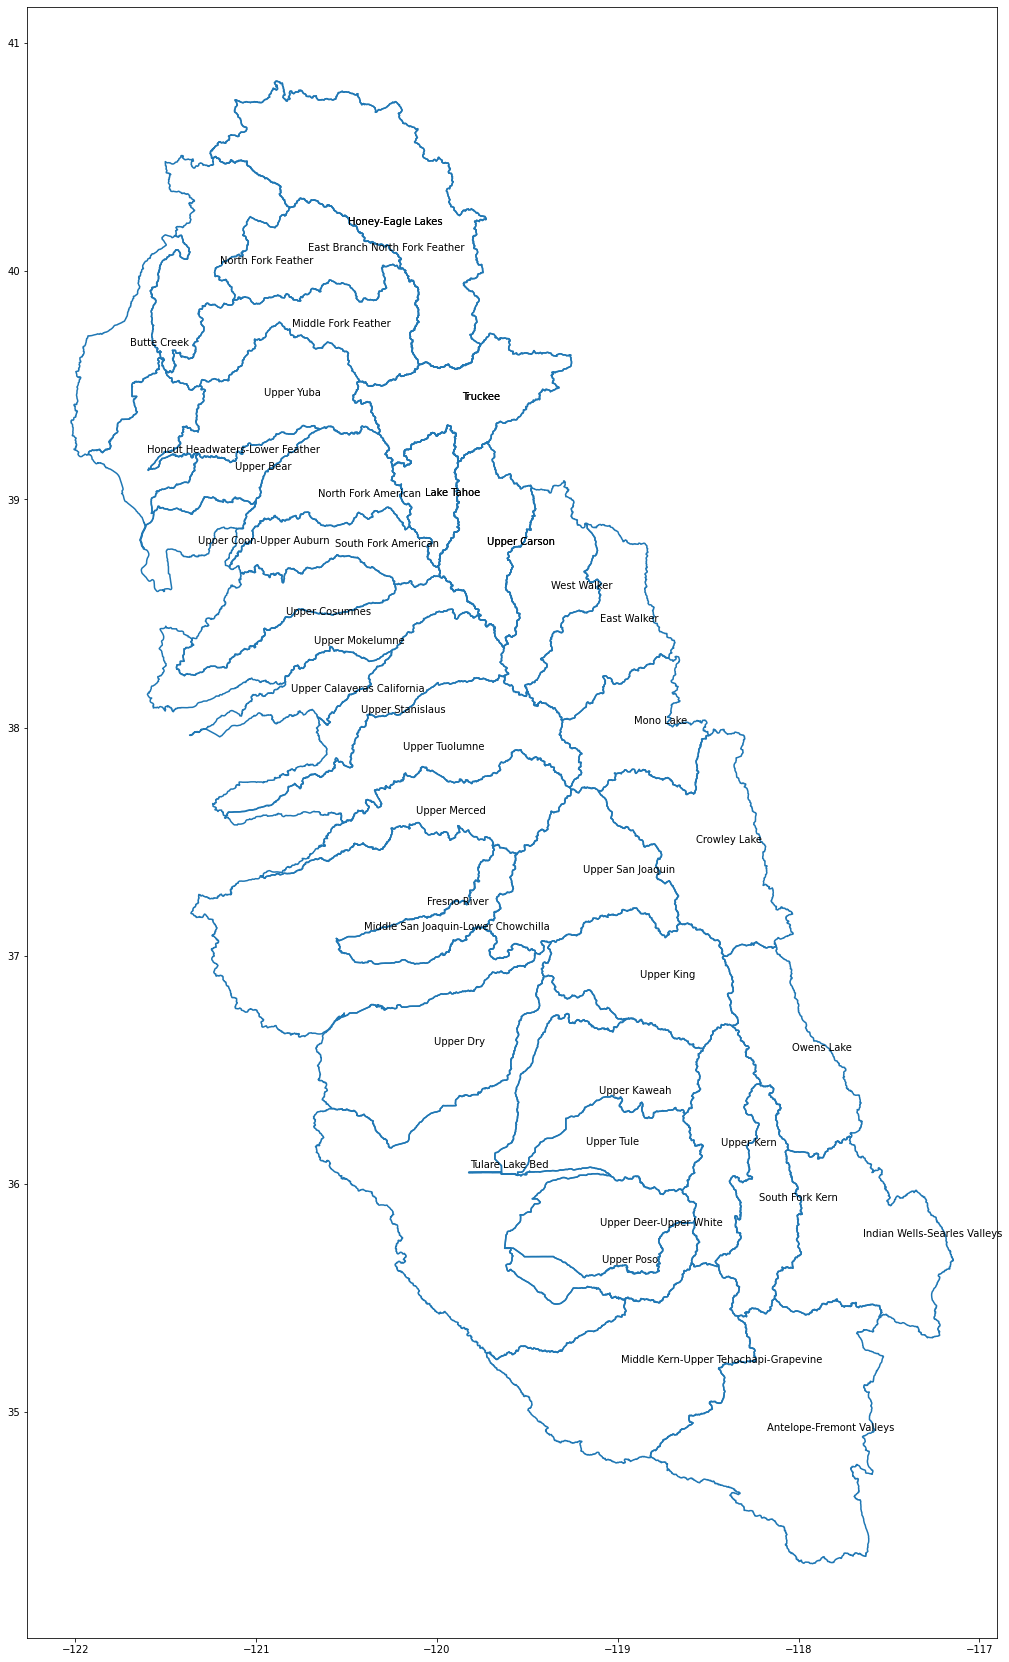

In [60]:
f,ax=plt.subplots(figsize=(30,30))
sn_watersheds.boundary.plot(ax=ax)
for i in sn_watersheds.index:
    tmp = sn_watersheds[(sn_watersheds.index==i)]
    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
    name = tmp.name[i]
    ax.text(x,y,name)

In [61]:
# san joaquin watershed
targets = ['Upper San Joaquin','Upper Tuolumne']
names = sn_watersheds.name
tmp =[names[i] in targets for i in range(len(names))]
idx = np.arange(44)[tmp]
tmp1 = sn_watersheds[sn_watersheds.index == 1]
tmp2 = sn_watersheds[sn_watersheds.index == 2]
tmp3 = tmp1.append(tmp2)
tmp3

# san joaquin watershed
targets = ['Upper San Joaquin','Upper Tuolumne','Upper King','Upper Merced','Upper Kaweah','Upper Kern','Upper Tule']
sj = sn_watersheds[sn_watersheds.name == targets[0]]
for t in range(1,len(targets)):
    tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
    sj = sj.append(tmp)
sj.name
sj.to_file('upper_watersheds.shp')


In [91]:
# san joaquin watershed
# san joaquin watershed
targets = ['Upper San Joaquin','Upper Tuolumne','Upper King','Upper Merced','Upper Kaweah','Upper Kern','Upper Tule']
sj = sn_watersheds[sn_watersheds.name == targets[0]]
for t in range(1,len(targets)):
    tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
    sj = sj.append(tmp)

#sj = sn_watersheds[(sn_watersheds.name=='Upper San Joaquin') or (sn_watersheds.name == 'Upper Tuolumne')]
# clip swe for every year
import datetime

fire_time = 10 #yrs
swe_sj = {}
swe_sj_burned = {}
swe_sj_unburned = {}
sai_sj = {}
sai_sj_burned = {}
sai_sj_unburned = {}

gpp_sj = {}
gpp_tot_sj ={}
gpp_sj_burned = {}
gpp_sj_unburned = {}
gpp_tot_sj_burned ={}
gpp_tot_sj_unburned ={}
ndvi_sj = {}
ndvi_sj_burned = {}
ndvi_sj_unburned = {}
for yr in range(2000,2016):
    timestop =datetime.datetime(yr,10,1)
    timestart = datetime.datetime(yr-fire_time,10,1)
    prev_fires = fire_sn[fire_sn['dt']<timestop]
    prev_fires = prev_fires[prev_fires['dt']>timestart]

    swe = rxr.open_rasterio(data_dir + 'max_swe'+str(yr)+'.tif')
    swe = swe.rio.write_crs(sj.crs)
    clipped = swe.rio.clip(sj.geometry,all_touched=True)
    swe_sj[yr]=clipped
    out_fire = clipped.rio.clip(prev_fires.geometry,all_touched=True, from_disk=True, invert = True)
    swe_sj_unburned[yr]=out_fire
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    swe_sj_burned[yr]=in_fire

    #SAI
    sai = rxr.open_rasterio(pe_data_dir + 'sai_'+str(yr)+'.tif')
    clipped = sai.rio.clip(sj.geometry,all_touched=True)

    clipped[np.where(clipped==np.inf)]=np.nan
    clipped[np.where(clipped>3000)]=np.nan
    clipped[np.where(clipped<0)]=np.nan
    sai_sj[yr]=clipped
    out_fire= clipped.rio.clip(prev_fires.geometry,all_touched=True, from_disk=True, invert = True)
    sai_sj_unburned[yr] = out_fire
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    sai_sj_burned[yr]=in_fire
    # GPP
    id = yr-2000
    gpp_means = []
    gpp_means_burned = []
    gpp_means_unburned = []
    gpp_all = {}
    gpp_all_burned = {}
    gpp_all_unburned = {}
    for mo in range(1,13):
        gppmean = 0
        gppmean_burned = 0
        try:
            tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(id)+'_'+str(mo)+'.tif')
            clipped = tmp.rio.clip(sj.geometry,all_touched=True)
            clipped[np.where(clipped>5000)] = np.nan
            gppmean = np.nanmean(clipped)
            gpp_all[mo]=clipped
            out_fire= clipped.rio.clip(prev_fires.geometry,all_touched=True, from_disk=True, invert = True)
            in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
            gpp_all_burned[mo]=in_fire
            gpp_all_unburned[mo]=out_fire
            gppmean_burned = np.nanmean(in_fire)
            gppmean_unburned = np.nanmean(out_fire)
        except:
            continue
        gpp_means.append(gppmean)
        gpp_means_burned.append(gppmean_burned)
        gpp_means_unburned.append(gppmean_unburned)
    max_mo = np.nanargmax(gpp_means)+1
    gpp = rxr.open_rasterio(data_dir+'modis_clip_'+str(id)+'_'+str(max_mo)+'.tif')
    clipped = gpp.rio.clip(sj.geometry,all_touched=True)
    clipped[np.where(clipped>5000)] = np.nan
    gpp_sj[yr]=clipped
    out_fire= clipped.rio.clip(prev_fires.geometry,all_touched=True, from_disk=True, invert = True)
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    gpp_sj_burned[yr]=in_fire
    gpp_sj_unburned[yr]=out_fire
    gpp_sum = np.zeros((clipped.shape[1:]))
    for k in gpp_all.keys():
        gpp_sum += gpp_all[k][0,:,:]
    gpp_tot_sj[yr]=gpp_sum
    gpp_sum_burned = np.zeros((in_fire.shape[1:]))
    gpp_sum_unburned = np.zeros((out_fire.shape[1:]))
    for k in gpp_all_burned.keys():
        gpp_sum_burned += gpp_all_burned[k][0,:,:]
    gpp_tot_sj_burned[yr]=gpp_sum_burned
    for k in gpp_all_unburned.keys():
        gpp_sum_unburned += gpp_all_unburned[k][0,:,:]
    gpp_tot_sj_unburned[yr]=gpp_sum_unburned


    #NDVI
    ndvi = rxr.open_rasterio(data_dir + 'pe_snow_fires_data/max-ndvi/max-ndvi-' + str(yr)+'.tif')
    #pe = pe.rio.write_crs(sj.crs)
    clipped = ndvi.rio.clip(sj.geometry,all_touched=True)
    out_fire= clipped.rio.clip(prev_fires.geometry,all_touched=True, from_disk=True, invert = True)
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True, invert = False)
    ndvi_sj[yr]=clipped
    ndvi_sj_burned[yr]=in_fire
    ndvi_sj_unburned[yr] = out_fire



In [149]:
in_fire[np.where(in_fire==0)]

In [92]:
gpp_by_month = np.zeros((clipped.shape[1:]))
gpp_by_month_burned = np.zeros((clipped.shape[1:]))
gpp_by_month_unburned = np.zeros((clipped.shape[1:]))

for yr in range(2000,2016):
    for mo in range(1,13):
            gppmean = 0
            gppmean_burned = 0
            try:
                tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(yr-2000)+'_'+str(mo)+'.tif')
                clipped = tmp.rio.clip(sj.geometry,all_touched=True)
                clipped[np.where(clipped>5000)] = np.nan
                gppmean = np.nanmean(clipped)
                gpp_by_month[yr-2000, mo-1] = gppmean
                in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
                gpp_all_burned[mo]=in_fire
                gppmean_burned = np.nanmean(in_fire)
                gpp_by_month_burned[yr-2000, mo-1] = gppmean_burned
                out_fire = clipped.rio.clip(prev_fires.geometry, all_touched= False, from_disk = True,invert=True)
                gppmean_unburned = np.nanmean(out_fire)
                gpp_by_month_unburned[yr-2000, mo-1] = gppmean_unburned
            except:
                continue


In [93]:
keys = range(2000,2015)
swe_means = [np.nanmean(swe_sj[k]) for k in keys]
sai_means = [np.nanmean(sai_sj[k]) for k in keys]
gpp_means = [np.nanmean(gpp_sj[k+1]) for k in keys]
ndvi_means = [np.nanmean(ndvi_sj[k+1]) for k in keys]
gpp_tot_means = [np.nanmean(gpp_tot_sj[k+1]) for k in keys]
swe_means_burned = [np.nanmean(swe_sj_burned[k]) for k in keys]
sai_means_burned = [np.nanmean(sai_sj_burned[k]) for k in keys]
gpp_means_burned = [np.nanmean(gpp_sj_burned[k+1]) for k in keys]
ndvi_means_burned = [np.nanmean(ndvi_sj_burned[k+1]) for k in keys]
gpp_tot_means_burned = [np.nanmean(gpp_tot_sj_burned[k+1]) for k in keys]
swe_means_unburned = [np.nanmean(swe_sj_unburned[k]) for k in keys]
sai_means_unburned = [np.nanmean(sai_sj_unburned[k]) for k in keys]
gpp_means_unburned = [np.nanmean(gpp_sj_unburned[k+1]) for k in keys]
ndvi_means_unburned = [np.nanmean(ndvi_sj_unburned[k+1]) for k in keys]
gpp_tot_means_unburned = [np.nanmean(gpp_tot_sj_unburned[k+1]) for k in keys]

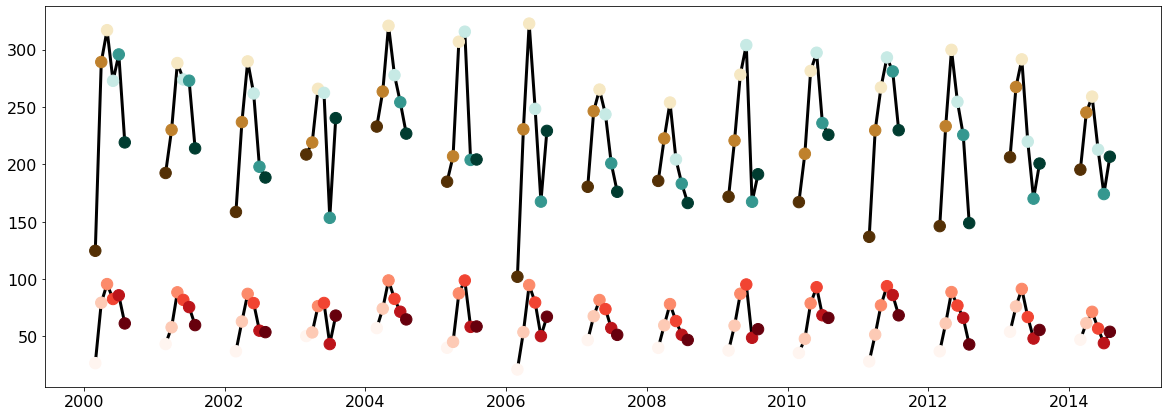

In [94]:
f,ax=plt.subplots(figsize=(20,7))
for yr in range(2000,2015):
    months = range(3,9)
    midx = [m-1 for m in months]
    data= gpp_by_month_unburned[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='BrBG',s=130, zorder=2.5)

for yr in range(2000,2015):
    months = range(3,9)
    midx = [m-1 for m in months]
    data= gpp_by_month_burned[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='Reds',s=130, zorder=2.5)
    
    

plt.show()


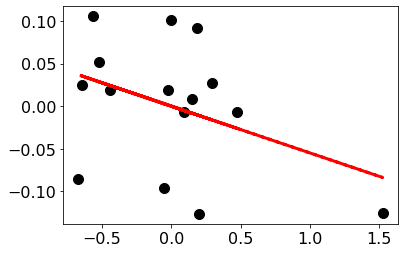

In [95]:
f,ax=plt.subplots()
x = normalize(sai_means)
y = normalize(gpp_means)
ax.plot(x,y,'ko')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--")

-0.22210899866177178 0.2665589125691819 0.048801339090044894


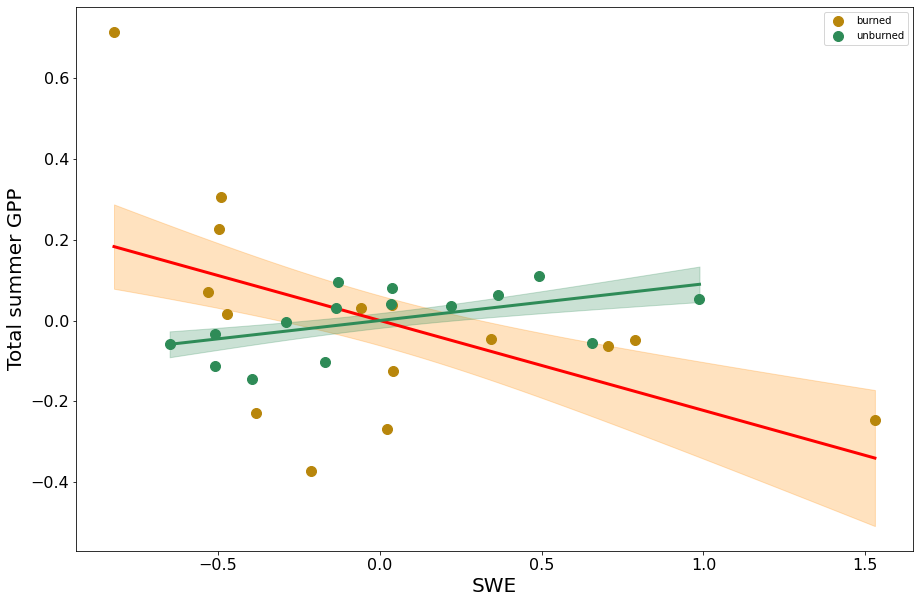

In [141]:
plt.style.use(home_dir+'stylefile.mplstyle')
f,ax=plt.subplots(figsize=(15,10))

x = normalize(swe_means_burned)
y = normalize(gpp_tot_means_burned)
#x = swe_means_burned
#y = gpp_means_burned
ax.plot(x,y,'o',color='darkgoldenrod',label='burned')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
#ax.plot(x,p(x),"r--")

n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='darkorange')
ax.plot(t, yi,'-',color='red')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, r_value**2,p_value)

x = normalize(swe_means_unburned)
y = normalize(gpp_means_unburned)
ax.plot(x,y,'o',color='seagreen',label='unburned')
n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='seagreen')
ax.plot(t, yi,'-',color='seagreen')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#ax.plot(x,p(x),":",color='seagreen')
ax.set_xlabel('SWE')
ax.set_ylabel('Total summer GPP')
ax.legend()
plt.show()

In [107]:
for yr in range(2000,2016):
    tmp=sai_sj_unburned[yr][0,:,:]
    tmp2 = tmp[np.where(~np.isnan(tmp))]


In [116]:
in_fire[np.where(in_fire==0)]=np.nan
in_fire.plot()

    #NDVI
    ndvi = rxr.open_rasterio(data_dir + 'pe_snow_fires_data/max-ndvi/max-ndvi-' + str(yr)+'.tif')
    #pe = pe.rio.write_crs(sj.crs)
    clipped = ndvi.rio.clip(sj.geometry,all_touched=True)
    out_fire= clipped.rio.clip(prev_fires.geometry,all_touched=True, from_disk=True, invert = True)
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True, invert = False)
    ndvi_sj[yr]=clipped
    ndvi_sj_burned[yr]=in_fire
    ndvi_sj_unburned[yr] = out_fire

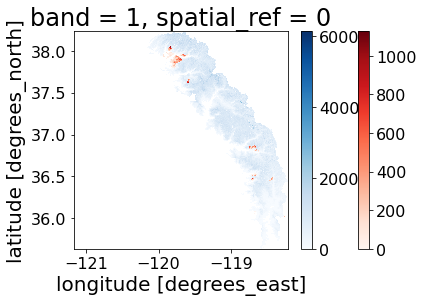

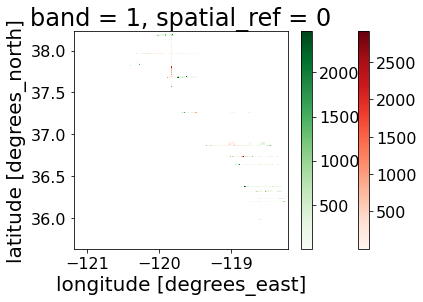

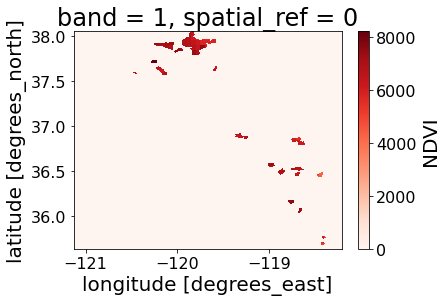

In [ ]:
k=2000
f,ax=plt.subplots()
swe_sj_burned[k].plot(ax=ax,cmap='Reds')
swe_sj_unburned[k].plot(ax=ax,cmap='Blues')
plt.show()
k=2015
f,ax=plt.subplots()
sai_sj_burned[k].plot(ax=ax,cmap='Reds')
sai_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()
k=2000
f,ax=plt.subplots()
ndvi_sj_burned[k].plot(ax=ax,cmap='Reds')
#ndvi_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()
k=2000
f,ax=plt.subplots()
gpp_sj_burned[k].plot(ax=ax,cmap='Reds')
#ndvi_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()


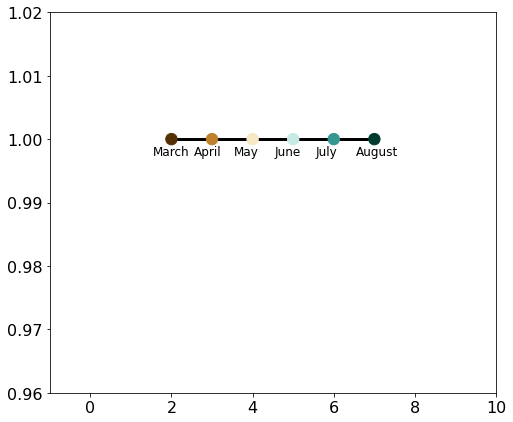

In [97]:
f,ax=plt.subplots(figsize=(8,7))
months = range(3,9)
texts = ['March','April','May','June','July','August']
midx = [m-1 for m in months]
data= [1,1,1,1,1,1]
dates = [datetime.datetime(yr,m,1) for m in months]
ax.plot(midx,data,'k-')
ax.scatter(midx,data,c=range(6), cmap='BrBG',s=130, zorder=2.5)
ax.set_xlim(-1,10)
ax.set_ylim(0.96,1.02)

for i in range(len(midx)):
    ax.text(midx[i]-0.45,data[i]-0.0025,texts[i],size=12)

plt.show()